# Fictitious Degradation Dataset
For each experiment and for each loading condition there are different degradation paths that have some common
characteristics which we should discover.


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

/home/charilaos/.local/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
## imports that are related to the fictitious dataset:
from fictitious_example.dataset_utils import lhs_sample,transform_exp_data_to_random_signal_params,add_disturbances_in_signal,get_dat,get_graph_training_data,get_graph_training_data_multiple_experiments

In [3]:
p = {"rate_shift": FloatSlider(min = -2.5, max = 2.5, steps = 40), 
    "concentration_shift": FloatSlider(min = -2.5, max = 2.5, steps = 40),
     "rate_shift1": FloatSlider(min = -2.5, max = 2.5, steps = 40), 
    "concentration_shift1": FloatSlider(min = -2.5, max = 2.5, steps = 40),
    "rate_shift2": FloatSlider(min = -2.5, max = 2.5, steps = 40), 
    "concentration_shift2": FloatSlider(min = -2.5, max = 2.5, steps = 40)}



In [4]:
conditions = [{"load" : 100,"rpm":1000}, {"load":150, "rpm" : 1500} , {"load" : 200, "rpm" : 1750}]

all_params = None
@interact(**p)
def aa(rate_shift, concentration_shift, rate_shift1,concentration_shift1, rate_shift2, concentration_shift2):
    t  = np.linspace(0,2,1000)

    base_rate = 1.0;
    #rate_shift = 0.;
    #v1 = tfd.Gamma(concentration = t**(2+0.1),rate = rates+rate_shift).sample(1).numpy().T
    #v2 = tfd.Gamma(concentration = t**(2-0.1),rate = rates).sample(1).numpy().T
    base_concentration = 3
    
    def plt_with_params(conc, rate, col):
        for k in range(0,10):
            v1 = tfd.Gamma(concentration = t**(conc),rate = rate).sample(1).numpy().T
            v1= np.cumsum(v1)
            v1 = v1[v1 < 60]
            pplot.plot(v1, col)
            
        
    all_params = [[rate_shift, concentration_shift],[rate_shift1, concentration_shift1],[rate_shift2, concentration_shift2]]
    col = ["C0","C1", "C2"];
    
    for pp in zip(all_params, col):
        plt_with_params(pp[0][0]+base_concentration, pp[0][1]+base_rate, pp[1])

        
#pplot.plot(np.cumsum(v2))

#pplot.plot()


interactive(children=(FloatSlider(value=0.0, description='rate_shift', max=2.5, min=-2.5), FloatSlider(value=0…

In [5]:
#all_params = [1.6,-1.2,1.1,-0.2,-0.3,-1.1]
#rates = all_params[0::2]
#concentrations= all_params[1::2]

base_rate = 1.0
rates_shift = 0.9

base_concentration = 3.
concentration_shifts = 0.1;
def make_experiments(nexp_per_case = 5, ncases = 3,base_rate = base_rate, rates_shift = rates_shift , base_concentration = base_concentration, concentration_shifts = concentration_shifts):
    rates = [base_rate,base_rate-rates_shift,base_rate+rates_shift]
    concentrations = [base_concentration,base_concentration-concentration_shifts,base_concentration+concentration_shifts]
    params = [(r,c) for r,c in zip(rates, concentrations)]

    def func(case):
        """
        Create a series of latent variable paths corresponding to experiments in different conditions. 
        Each latent variable is realized 
        """
        r,c = params[case]
        t  = np.linspace(0,1,3000)
        # For every different loading condition, 
        # corresponds a different rate and concentration parameter for a gamma distribution
        # Failure is defined when a threshold on the accumulated gamma steps is reached. 

        v1 = tfd.Gamma(concentration = 0.02+t**(c),rate = r).sample(1).numpy().T
        v1= np.cumsum(v1)
        v1 = v1[v1 < 250]
        return v1

    # Create the latent underlying data:
    #nexp_per_case = 5; # 5 experiments for each case:
    #ncases=3;
    all_dat = [];
    exp_index = 0;
    for kk in range(nexp_per_case):    
        for nn in range(ncases):
            exp_dat = np.diff(func(nn))
            exp_dat = (func(nn))

            df_dat = {"case" : nn, "exp_index" : exp_index, "latent_values" : exp_dat, "ttf" : len(exp_dat)-np.array([rr for rr in range(len(exp_dat))])};
            all_dat.append(df_dat)
            exp_index += 1;
            
    return all_dat
all_dat = make_experiments()



<Figure size 1440x1440 with 0 Axes>

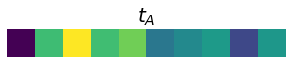

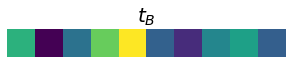

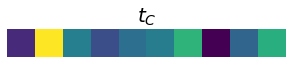

In [6]:
pplot.figure(figsize=(20,20))
kk = ["$t_A$", "$t_B$", "$t_C$"]
for i in range(3):
    #pplot.subplot(1,3,i+1)
    pplot.figure(figsize=(5,10))
    
    pplot.imshow(np.random.randn(10,1).T)
    pplot.axis("off")
    pplot.title("%s"%(kk[i]), fontsize = (20))
        
        
    
pplot.subplots_adjust(wspace = 2)

\begin{equation}
p(z_c | f(X_{t_A, t_B, \cdots}))
\end{equation}

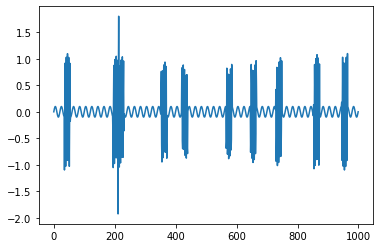

In [7]:
from fictitious_example.dataset_utils import *
d = all_dat[0]
rr = 10;

s = get_signal_for_segments(d['latent_values'], speed = 50, rr=rr)
#pplot.plot(s[[0,50,100]].T)
pplot.plot(s[[0]].T)


In [8]:
#for d in all_dat

get_signal_for_segments = lambda exp_dat_, speed : add_disturbances_in_signal(transform_exp_data_to_random_signal_params(exp_dat_, rr =rr), speed)

l = d['latent_values']
l2 =d['ttf']
reshape_ttf  = lambda l : np.mean(l[:-(l2.shape[0]%rr)].reshape([-1,rr]),1)
y = reshape_ttf(l2)
case = d['case']
speed_dict = {0:20, 1:25, 2:30};
X = get_signal_for_segments(l, speed= speed_dict[case])
eid = d['exp_index']
exp_data = {"X" : X , "eid" : eid , "y" : y, "case" : case}

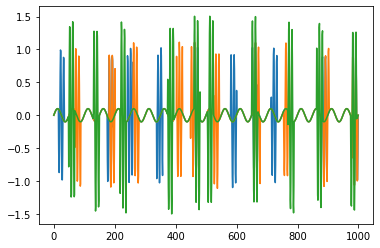

In [9]:
pplot.plot(exp_data['X'][0,:])
pplot.plot(exp_data['X'][10,:])
pplot.plot(exp_data['X'][100,:])


## Mini - graphnets
* **Edge**: Object keeping edge data - in this example dt and a latent output from the sender node.
* **Node**: Object keeping node data - in this example a latent variable (some function of observation and edge output).
* **Graph**: An object keeping edges/nodes corresponding to sequences of observations (and predictions?)
* **GraphNet**: An object defining how the computation happens on a graph object. It is a sequence of transformations and aggregations performed on edge and node states.

The information flowing through the graph may be better implemented in a sequential MC way. The nodes output samples or distributions, that are propagated by the edge to the time-instant corresponding to the receiver node. The edge aggregation function can be the application of Bayes rule in some way. 

## Utilities to make construction easier

In [10]:
from fictitious_example.minigraphnets import  *
def make_gamma_node_observation_mlp():
    """
    Takes as input a node state and returns a gamma probability distribution
    """
    seq = keras.Sequential()
    NParams= 1;
    NSamples = 10;
    n_gamma_internal = 100;
    
    seq.add(Dense(n_gamma_internal, use_bias = True, activation = "relu"))
    seq.add(Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x)));
    def instantiate_gamma(t):
        return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])
    
    
    seq.add(
        tfp.layers.DistributionLambda(
            make_distribution_fn = lambda t: instantiate_gamma(t),
            convert_to_tensor_fn= lambda s : s.sample(NSamples)))  
    
    return seq
    
    

def make_edge_function(n_edge_state_input = None,n_edge_state_output = None, n_node_state_input = None):    
    edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
    node_state_sender_in = Input(shape = (n_node_state_input), name = "node_sender");
    node_state_receiver_in = Input(shape = (n_node_state_input), name = "node_receiver");

    ## Building the edge MLP:
    edge_out = keras.layers.concatenate([edge_state_in, node_state_sender_in, node_state_receiver_in])
    
    edge_out = Dense(100, activation = "sigmoid", use_bias = False)(edge_out)
    edge_out = Dense(n_edge_state_output, activation = None, use_bias = False)(edge_out)
    
    edge_mlp = Model(
        inputs = [edge_state_in, node_state_sender_in, node_state_receiver_in ] ,
        outputs = edge_out)
    
    return edge_mlp


def make_edge_function_gi(n_edge_state_input = None, n_edge_state_output = None, n_node_state_input = None):
    # for graph independent.
    if n_edge_state_output is None:
        n_edge_state_output = n_edge_state_input
            
    edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
    edge_out = edge_state_in
    
    edge_out = Dense(100, activation = "sigmoid", use_bias = False)(edge_out)
    edge_out = Dense(n_edge_state_output, activation = None, use_bias = False)(edge_out)
    
    edge_mlp = Model(inputs = edge_state_in,outputs = edge_out)
    
    return edge_mlp


def per_node_edge_aggregator(node_incoming_edges):
    """
    This seems to get the pure edge state.
    I can pass the node state in the edge 
    state if I want to have this as well.
    """
    val  = tf.reduce_mean(tf.stack(node_incoming_edges),0) # replace with something better?
    return val

def aggregated_edge_to_node_function(n_edge_state_input = None, n_node_state_input = None):
    # In order to treat uniformly the case of no edges, it is better if edge 
    # contributions are simply added to the node state (perhaps one could
    # think some more interesting operation performed here)
    None

def make_node_function(n_edge_state_input = None,n_node_state_input = None):
    agg_edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state_agg");
    node_prev_state = Input(shape = (n_node_state_input), name = "node_sender");

    ## Building the edge MLP:
    node_out = keras.layers.concatenate([agg_edge_state_in, node_prev_state]);
    
    node_out = Dense(100, activation = "sigmoid")(node_out)
    node_out = Dense(n_node_state_input, activation = None, use_bias = False)(node_out)
    
    node_out_model = Model(inputs = [agg_edge_state_in, node_prev_state] ,outputs = node_out)
    
    return node_out_model


def make_conv_input_head_node_function(edge_input_dummy_size , nfilts = 64, nfilts2 = 128, ksize = 2, output_size = None):
    
    xin_node_ts = tf.keras.Input(shape = (None, 1) , name = "timeseries_input"); 
    xin_edge_dummy = tf.keras.Input(shape = ( edge_input_dummy_size), name = "edge_input_dummy");
    
    yout = Conv1D(kernel_size = 1 , filters = 100, strides = 1, use_bias = False)(xin_node_ts)
    yout = Conv1D(kernel_size=ksize,filters = nfilts, strides=2, use_bias= False)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,use_bias= False)(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,activation  = "relu",use_bias= True)(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

    yout = Conv1D(kernel_size=ksize, strides=2, filters = nfilts2,use_bias= False)(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= False)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= False)(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)



    yout = keras.layers.GlobalAveragePooling1D()(yout)
    yout = Dense(output_size, use_bias = False)(yout)
    mconv = keras.Model(inputs = [xin_edge_dummy,xin_node_ts], outputs = yout)
    # mconv.summary()
    return mconv


In [11]:
F = make_conv_input_head_node_function(edge_input_dummy_size=1,output_size = 15)
F.inputs

[<tf.Tensor 'edge_input_dummy:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'timeseries_input:0' shape=(None, None, 1) dtype=float32>]

## Classes for `Node` and `Edge` and `Graph`
These are classes encapsulating the attributes corresponding objects. Their behavior and the functions mutating them are implemented in a separate class (`GraphNet`) so that the graphNet can be evaluated with arbitrary graphs.

In [12]:
from fictitious_example import dataset_utils,minigraphnets

In [13]:
class GraphNet:
    """
    Input is a graph and output is a graph.
    """
    def __init__(self, edge_function, node_function, edge_aggregation_function, node_to_prob_function):
        self.edge_function             = edge_function
        self.node_function             = node_function
        self.edge_aggregation_function = edge_aggregation_function        
        self.node_to_prob_function = node_to_prob_function
        # Needed to treat the case of no edges.
        # If there are no edges, the aggregated edge state is zero.
        
        self.edge_input_size = self.edge_function.inputs[0].shape[1] # first input of edge mlp is the edge state size by convention.
        
    def weights(self):
        all_weights = [ *self.edge_function.weights, *self.node_function.weights]
        if self.node_to_prob_function is not None:
            all_weights.extend(self.node_to_prob_function.weights)
        
        if self.edge_aggregation_function is not None and not isinstance(self.edge_aggregation_function, type(tf.reduce_mean)):            
            all_weights.extend(self.edge_aggregation_function.weights)
            
        return all_weights
    
    def observe_nodes(self, graph):
        probs = [];
        for n in graph.nodes:
            probs.append(self.node_to_prob_function(n.node_attr_tensor))
            
        return probs
        
    def observe_node(self, node):
        self.node_to_prob_function(node)
        
    def graph_eval(self, graph):
        # Evaluate all edge functions:
        self.eval_edge_functions(graph)
        
        batch_size             = graph.nodes[0].shape[0]; # This will be related to the input graph tuple. 
        
        edge_input_size = self.edge_input_size ; # This relates to the graphnet being evaluated.
        
        # Aggregate edges per node:
        edge_to_node_agg_dummy = np.zeros([batch_size, edge_input_size]);
        
        for n in graph.nodes:
            if len(n.incoming_edges) is not 0:                
                if self.edge_aggregation_function is not None:
                    edge_to_node_agg = self.edge_aggregation_function([e.edge_tensor for e in n.incoming_edges])
                    node_attr_tensor = self.node_function([edge_to_node_agg, n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                else:
                    node_attr_tensor = self.node_function([edge_to_node_agg_dummy,n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                    
            else:
                node_attr_tensor = self.node_function([edge_to_node_agg_dummy, n.node_attr_tensor])
                n.set_tensor(node_attr_tensor)
        
        return graph
    
    def prob_graph_eval(self,graph):
        """
        Compute the graphical model defined in parallel to the 
        graphnet. The nodes correspond to instants in time. Edges have time differences as features.
        * For every sender edge sample a set of values
        * according to an MLP that takes as input the latent state of the sender and receiver, and dt,
          propagate the sampled times-to-failure
        * evaluate the sampled times-to-failure according to the likelihood of the future state
          keep a percentage of the best particles according to that likelihood and resample according 
          to the likelihood of the receiver node.
        * The emmited edge aggregation is the particles
        
        """
           
    def eval_edge_functions(self,graph):
        """
        Evaluate all edge functions
        """
        if self.edge_aggregation_function is None:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor])
                edge.set_tensor(edge_tensor)
                
        else:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor, edge.node_from.node_attr_tensor, edge.node_to.node_attr_tensor])
                edge.set_tensor(edge_tensor)
    
    

In [14]:
n_node_state_input , n_edge_state_input = [15,15]
n_edge_output = n_edge_state_input;
#n_edge_output_gi = n_edge_state_input
n_edge_output_gi = 15
n_node_state_input_gi , n_edge_state_input_gi = [1000,1]

batch_size = 989;

edge_mlp = make_edge_function(n_edge_state_input,n_edge_output, n_node_state_input) # THe node state is used for two nodes.
edge_mlp([vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input), np.random.randn(batch_size,n_node_state_input)]])

node_mlp = make_node_function(n_edge_state_input, n_node_state_input)
node_to_prob_mlp = make_gamma_node_observation_mlp();
node_mlp([vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input)]])

edge_mlp_gi = make_edge_function_gi(n_edge_state_input = n_edge_state_input_gi, n_edge_state_output= n_edge_output_gi, n_node_state_input = n_node_state_input_gi)
node_mlp_gi = make_conv_input_head_node_function(edge_input_dummy_size=n_edge_state_input_gi, output_size = n_node_state_input)
node_mlp_gi([np.random.randn(batch_size,n_edge_state_input_gi),np.random.randn(batch_size,1000,1)])
graph_indep = GraphNet(edge_function = edge_mlp_gi, node_function = node_mlp_gi, edge_aggregation_function= None, node_to_prob_function= None)

edge_aggregation_function = per_node_edge_aggregator

gn = GraphNet(edge_function = edge_mlp, node_function=node_mlp, edge_aggregation_function=edge_aggregation_function, node_to_prob_function= node_to_prob_mlp)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [15]:
gn.edge_function.input

[<tf.Tensor 'edge_state:0' shape=(None, 15) dtype=float32>,
 <tf.Tensor 'node_sender:0' shape=(None, 15) dtype=float32>,
 <tf.Tensor 'node_receiver:0' shape=(None, 15) dtype=float32>]

In [16]:
#n_edge_state_input_gi
#node_mlp_gi = make_conv_input_head_node_function(edge_input_dummy_size=n_edge_state_input_gi, output_size = n_node_state_input)
        
        

        

In [17]:
node_mlp_gi = make_conv_input_head_node_function(edge_input_dummy_size=n_edge_state_input_gi, output_size = n_node_state_input)
node_mlp_gi.inputs

[<tf.Tensor 'edge_input_dummy_2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'timeseries_input_2:0' shape=(None, None, 1) dtype=float32>]

In [18]:
print("Edge MLP:")
print(edge_mlp_gi.input.shape, edge_mlp_gi.output.shape)
print("Node MLP:")

print(node_mlp_gi.input[0].shape,node_mlp_gi.input[1].shape, node_mlp_gi.output.shape)
#graph_out = graph_indep.graph_eval(graph_data[1].copy())
#graph_data[1].edges[0].edge_tensor.shape


Edge MLP:
(None, 1) (None, 15)
Node MLP:
(None, 1) (None, None, 1) (None, 15)


In [19]:
batch_size = 10;
n1 = Node(np.random.randn(batch_size, 1000,1))
n2 = Node(np.random.randn(batch_size, 1000,1))
e12 = Edge(np.random.randn(batch_size, 1), n1,n2)
random_graph = Graph([n1,n2],[e12])

#graph_data.nodes[0].node_attr_tensor.shape,  graph_data.edges[0].edge_tensor.shape
def eval_graphnets(graph_data_):
    graph_out = graph_indep.graph_eval(graph_data_)
    graph_out = gn.graph_eval(graph_out)
    return node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)

eval_graphnets(random_graph)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tfp.distributions.Gamma 'sequential_distribution_lambda_Gamma' batch_shape=[10, 1] event_shape=[] dtype=float32>

In [20]:
batch_size = 10;
n1 = Node(np.random.randn(batch_size, 1000,1))
n2 = Node(np.random.randn(batch_size, 1000,1))
e12 = Edge(np.random.randn(batch_size, 1), n1,n2)
random_graph = Graph([n1,n2],[e12])

graph_indep.graph_eval(random_graph)
[n.shape for n in random_graph.nodes],[e.shape for e in random_graph.edges]
#gn.graph_eval(random_graph)
#gn.graph_eval(random_graph)

([TensorShape([10, 15]), TensorShape([10, 15])], [TensorShape([10, 15])])

In [21]:
n1 = Node(np.random.randn(batch_size, 15))
n2 = Node(np.random.randn(batch_size, 15))
e12 = Edge(np.random.randn(batch_size, 15), n1,n2)
random_graph2 = Graph([n1,n2], [e12])
gn.graph_eval(random_graph2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [22]:
random_graph.edges[0].shape

TensorShape([10, 15])

## The basic idea:
![alt-text](temporal_bayesian_graphnet.png)
Assuming this is markovian and I can capture something about the markov state with $z_i$, perhaps the second order links are not needed. Some more insight from what people in RL are using is needed to resolve this. 


### In more detail
* The input data, namely the raw time-series inputs and the difference in times for the observations,  are first transformed. The time-differences are simply projected to a 15 dimensional scalar and the time-series input is transformed using a convolutional neural network with global pooling to a 15 dimensional vector. 

* A second graph-net, that contains the causal links between the nodes of the graph, is then used to process the embedded quantities.
* The final inferred state is used to define the parameters of a `DistributionLambda` layer that is finally used to compute the final output. The final output is the time to failure for the final observation.

### Extensions
With adversarial learning the GraphNet should be able to infer prediction dependent and prediction independent states. This complicates implemetation (adversarial graph-nets would be yet another novel thing).

In [23]:
# Make dataset for training with GraphNets

In [24]:

d = all_dat[4]
if True:
    """
    Transforms the latent values to a timeseries segment. 
    
    The timeseries segment is used for prediction. The "case" input parameter contains the information of which loading case we are producing datra from.
    Different cases have a different background "noise". The network should learn to exploit this background for better prediction (different cases have different rates of damage accumulation).
    """
    a = d['latent_values']
    get_signal_for_segments = lambda exp_dat_, speed : add_disturbances_in_signal(transform_exp_data_to_random_signal_params(exp_dat_, rr =rr), speed)

    l = d['latent_values']
    l2 =d['ttf']

    def reshape_ttf(l_):
        trunc_l = l_[:-(l2.shape[0]%rr)] if (l2.shape[0]%rr)>0 else l_
        return np.mean(trunc_l.reshape([-1,rr]),1)
        
        
        
    #reshape_ttf  = lambda l : np.mean(l[:-(l2.shape[0]%rr)].reshape([-1,rr]),1)
    y = reshape_ttf(l2)
    case = d['case']
#reshape_ttf(l2)

#np.mean(l[:-(l2.shape[0]%rr)].reshape([-1,rr]),1)


In [25]:
from fictitious_example.minigraphnets import Node

In [26]:
#[*graph_indep.weights(), *gn.weights()]
#gn.weights()
graph_data,predictions = get_graph_training_data_multiple_experiments(all_dat, 100)


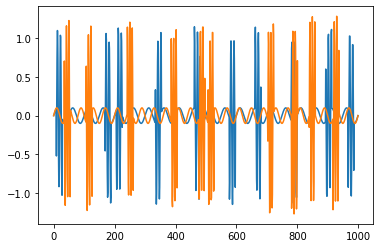

In [27]:
pplot.plot(graph_data[0].nodes[0].node_attr_tensor[0,:])
pplot.plot(graph_data[1].nodes[0].node_attr_tensor[0,:])

In [28]:
%matplotlib qt
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

graph_data,predictions = get_graph_training_data_multiple_experiments(all_dat, 100)

d = all_dat[0]
v = get_dat(d,10)
#graph_data , predictions = get_graph_training_data(v,400)
predictions = [p/ 350 for p in predictions]
loss_hist = []
for i in range(200):
    
    for graph_data_, predictions_ in zip(graph_data, predictions): # Loop for all experiments:
        with tf.GradientTape() as tape:
            prob_out = eval_graphnets(graph_data_.copy())

            all_weights = [*gn.weights(), *graph_indep.weights()];
            loss = tf.reduce_mean(-prob_out.log_prob(predictions_[np.newaxis].T))
            loss_hist.append(loss)
            grads = tape.gradient(loss, all_weights)
        if i % 10 == 0 :
            pplot.cla()
            times = np.linspace(0,np.max(predictions_),100)
            probs_est = prob_out.prob(times)
            ids_sort = np.argsort(predictions_)
            pplot.plot([r for r in range(len(ids_sort))],predictions_[ids_sort])
            vals = probs_est.numpy()[ids_sort].T
            pplot.pcolor([r for r in range(vals.shape[1])],times,vals)
            pplot.show()
            pplot.pause(0.1)
        
        opt.apply_gradients(zip(grads, all_weights))
    print(loss)
    
#other_graph = graph_indep.graph_eval(graph_data)
#[n.shape for n in other_graph.edges]
#[n.shape for n in other_graph.nodes]

tf.Tensor(0.00046314002, shape=(), dtype=float32)
tf.Tensor(-0.42059577, shape=(), dtype=float32)
tf.Tensor(-0.53065145, shape=(), dtype=float32)
tf.Tensor(-0.6004113, shape=(), dtype=float32)
tf.Tensor(-0.64156425, shape=(), dtype=float32)
tf.Tensor(-0.7668007, shape=(), dtype=float32)
tf.Tensor(-0.9481248, shape=(), dtype=float32)
tf.Tensor(-1.1105726, shape=(), dtype=float32)
tf.Tensor(-1.1884058, shape=(), dtype=float32)
tf.Tensor(-1.2630982, shape=(), dtype=float32)
tf.Tensor(-1.3319643, shape=(), dtype=float32)
tf.Tensor(-1.3900692, shape=(), dtype=float32)
tf.Tensor(-1.4308301, shape=(), dtype=float32)
tf.Tensor(-1.4779514, shape=(), dtype=float32)
tf.Tensor(-1.5242518, shape=(), dtype=float32)
tf.Tensor(-1.5668567, shape=(), dtype=float32)
tf.Tensor(-1.6011032, shape=(), dtype=float32)
tf.Tensor(-1.6299655, shape=(), dtype=float32)
tf.Tensor(-1.674573, shape=(), dtype=float32)
tf.Tensor(-1.6864514, shape=(), dtype=float32)
tf.Tensor(-1.7349857, shape=(), dtype=float32)
tf.Tenso

tf.Tensor(-2.6468976, shape=(), dtype=float32)
tf.Tensor(-2.6599314, shape=(), dtype=float32)
tf.Tensor(-2.7226968, shape=(), dtype=float32)
tf.Tensor(-2.7554884, shape=(), dtype=float32)
tf.Tensor(-2.655461, shape=(), dtype=float32)
tf.Tensor(-2.461152, shape=(), dtype=float32)
tf.Tensor(-2.4789782, shape=(), dtype=float32)
tf.Tensor(-2.7367523, shape=(), dtype=float32)
tf.Tensor(-2.049966, shape=(), dtype=float32)
tf.Tensor(-1.2677426, shape=(), dtype=float32)
tf.Tensor(-2.6398568, shape=(), dtype=float32)
tf.Tensor(-2.5610425, shape=(), dtype=float32)
tf.Tensor(-2.7069058, shape=(), dtype=float32)
tf.Tensor(-2.6313746, shape=(), dtype=float32)
tf.Tensor(-2.479167, shape=(), dtype=float32)
tf.Tensor(-2.7504542, shape=(), dtype=float32)
tf.Tensor(-2.730908, shape=(), dtype=float32)
tf.Tensor(-2.7249403, shape=(), dtype=float32)
tf.Tensor(-2.7938583, shape=(), dtype=float32)
tf.Tensor(-2.6899462, shape=(), dtype=float32)
tf.Tensor(-2.5788326, shape=(), dtype=float32)
tf.Tensor(-2.70379

In [29]:
#graph_indep.graph_eval(graph_data_.copy())
graph_data_.nodes[0].node_attr_tensor.shape

(100, 1000, 1)

In [30]:
pplot.plot(loss_hist)
pplot.show()

In [31]:
%matplotlib inline


In [32]:
from IPython.display import clear_output
#prob = eval_graphnets(graph_data.copy())
graph_data_val,predictions_val = get_graph_training_data_multiple_experiments(all_dat, 100)
#graph_data_val = graph_data.copy()
#predictions_val = predictions
predictions_val = [p/350 for p in predictions_val]
prob_out_val = [eval_graphnets(graph_data_val_.copy()).prob(times).numpy() for graph_data_val_ in graph_data_val]
clear_output()

In [33]:
len(prob_out_val)

15

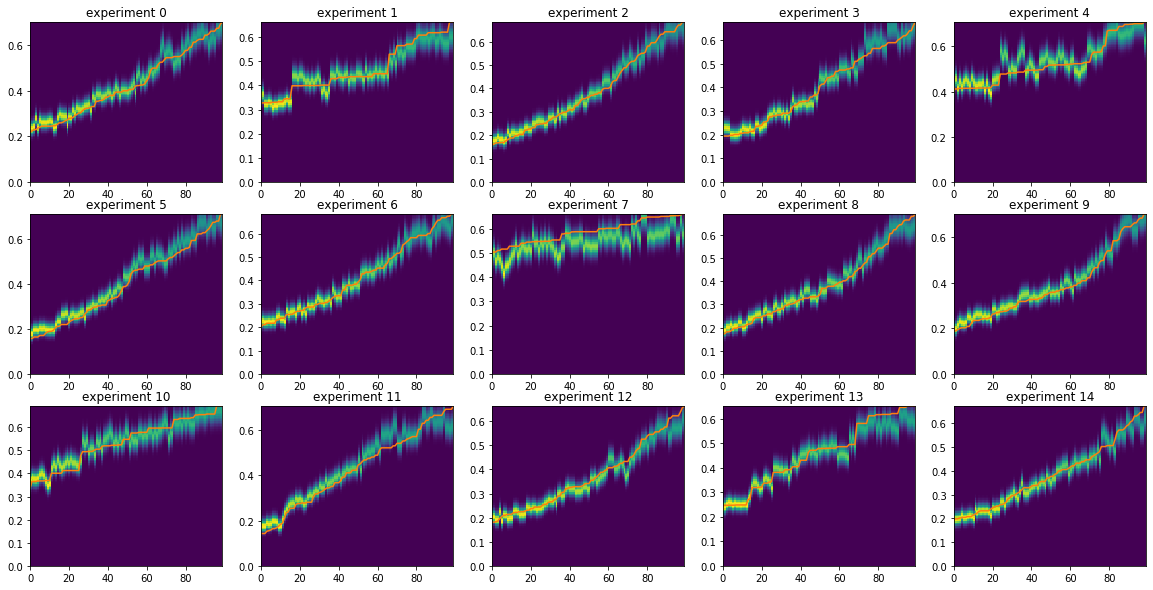

In [42]:
pplot.figure(figsize = (20,10));

for idx_experiment in range(0, len(prob_out_val)):
    pplot.subplot(3,5,idx_experiment +1, title = "experiment {}".format(idx_experiment))
    npoints_times = 100
    times = np.linspace(0,np.max(predictions_val[idx_experiment]),npoints_times)
    probs_est = prob_out_val[idx_experiment] 

    ids_sort = np.argsort(predictions_val[idx_experiment])
    
    pplot.plot([r for r in range(len(ids_sort))],predictions_val[idx_experiment][ids_sort],'C1')

    vals = probs_est[ids_sort].T
    pplot.pcolor([r for r in range(vals.shape[1])],times,vals)


## Predict using single point

In [39]:
X.shape

(223, 1000)

10

In [40]:
# a whole experiment:
exp_idx = 2
d = get_dat(all_dat[exp_idx])
y = d['y']
X = d['X'][...,np.newaxis]
n = Node(X)
g = Graph([n],[])
vals = eval_graphnets(g.copy())

## Graph with two observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())


## Graph with three observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())

TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'

In [485]:
#graph_indep.graph_eval(g2.copy())
#graph_data_val[0].edges[0].edge_tensor.shape#e01.edge_tensor.shape


In [486]:

X0.shape,X1.shape

((208, 1000, 1), (208, 1000, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'prob'

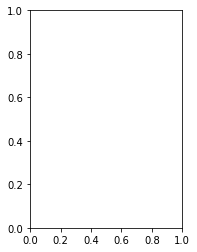

In [38]:
pplot.subplot(1,2,1)
#predictions_val[ids_sort.flatten()]
v = vals.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
# pplot.yscale("log")
# pplot.semilogy(y,"C1")
pplot.plot(y, "C1")

pplot.subplot(1,2,2)
v = vals2.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
#pplot.yscale("log")
#pplot.semilogy(y2_1,"C1")
pplot.plot(y2_1,"C1")


# Done. Success.